### transformers, PIL, 그리고 torch 라이브러리를 사용하여 CLIP 모델을 설정하고, 
### CUDA가 사용 가능한지 확인한 후 적절한 장치를 설정합니다.

In [64]:
# Import necessary libraries
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 과일 이미지 데이터셋을 다운로드하고, Hugging Face의 datasets 라이브러리를 사용하여 로드합니다. 
#### 데이터셋의 구조를 확인하고, 클래스 이름과 인덱스 간의 매핑을 생성합니다

In [31]:
# Load the fruit dataset
from datasets import load_dataset
dataset = load_dataset("C:/Users/PC/OneDrive - gachon.ac.kr/바탕 화면/ai-study/fruit-dataset")

# Preview the dataset structure
print(dataset)

class_map = { k:v for k, v in enumerate(dataset['train'].features['label'].names) }
class_names = [v for k,v in class_map.items()]
print(class_map)
print(class_names)

Resolving data files:   0%|          | 0/1600 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/400 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 400
    })
})
{0: 'apple', 1: 'asian pear', 2: 'banana', 3: 'cherry'}
['apple', 'asian pear', 'banana', 'cherry']


 #### CLIPProcessor와 CLIPModel을 불러오고, 이를 GPU 또는 CPU로 이동시킵니다.

### 파일 다운로드:

#### tokenizer_config.json, vocab.json, merges.txt, tokenizer.json, special_tokens_map.json, config.json, 
#### 그리고 pytorch_model.bin과 같은 파일들이 다운로드되었습니다.
#### 특히, pytorch_model.bin 파일은 모델의 가중치가 포함된 파일로, 크기가 상당히 큽니다(605MB).


In [35]:
# Load CLIP model and processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

C:\Users\PC\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\PC\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

C:\Users\PC\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

### classify_image 함수는 주어진 이미지를 특정 텍스트 목록과 비교하여, 이미지와 가장 잘 맞는 텍스트(클래스)를 예측합니다.
<br/><br/><br/>
## 이미지 입력 처리:
#### image가 파일 경로인 경우, Image.open(image)을 사용하여 이미지를 열어 PIL.Image 객체로 변환합니다.
#### 이미지가 PIL.Image 객체도 아니고, 경로도 아닐 경우 ValueError 예외를 발생시킵니다.

## 이미지와 텍스트 전처리:
#### processor를 사용하여 이미지를 모델이 처리할 수 있는 텐서 형태로 변환합니다. align_texts는 모델이 이미지와 비교할 텍스트의 리스트입니다.
#### inputs는 전처리된 이미지와 텍스트를 포함한 사전으로 반환됩니다.

## 토큰화된 텍스트 확인:
#### inputs['input_ids']는 텍스트가 토큰화된 후의 ID를 포함합니다.
#### processor.tokenizer.decode를 사용하여 토큰화된 텍스트 ID를 인간이 읽을 수 있는 형태로 디코딩합니다. 이는 모델이 실제로 어떤 텍스트를 사용하고 있는지 확인하는 데 유용합니다.

## 디바이스로 입력 이동:
#### 전처리된 입력을 GPU 또는 CPU로 이동시킵니다. device 변수는 사용 가능한 장치에 따라 이전에 설정되었습니다 (cuda 또는 cpu).

## 모델 예측:
#### torch.no_grad() 블록 내에서 모델을 실행하여 텍스트와 이미지 간의 유사도를 계산합니다. 이는 백프로파게이션을 비활성화하여 메모리 사용을 줄이고 계산을 가속화합니다.
#### logits_per_image는 이미지와 텍스트 사이의 유사도 점수를 나타내며, softmax 함수를 적용하여 이들을 확률로 변환합니다.
#### torch.argmax(probs, dim=1)를 사용하여 가장 높은 확률을 가진 텍스트(클래스)를 선택합니다.

## 결과 반환:
#### 함수는 예측된 텍스트의 인덱스(pred_text_idx.item()), 디코딩된 텍스트(decoded_text), 그리고 모든 텍스트에 대한 확률(probs)을 반환합니다.

In [46]:
import os
def classify_image(image, align_texts):
    # Check if the image is a file path
    if isinstance(image, str) and os.path.isfile(image):
        image = Image.open(image)
    elif not isinstance(image, Image.Image):
        # If the image is not a PIL Image and not a file path, raise an error
        raise ValueError("The provided image must be a PIL Image or a file path to an image.")
    # If 'image' is already a PIL Image, no conversion is needed

    # Process the image with the processor
    inputs = processor(text=align_texts, images=image, return_tensors="pt", padding=True)

    # To see the actual text used for alignment, inspect the tokenized text
    tokenized_text = inputs['input_ids']

    # Decode the tokenized text to see the human-readable format
    decoded_text = [processor.tokenizer.decode(ids) for ids in tokenized_text]

    # Move inputs to the device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image  # Image-to-text similarity scores
        probs = logits_per_image.softmax(dim=1)
        pred_text_idx = torch.argmax(probs, dim=1)

    # Return the class name with the highest probability
    return pred_text_idx.item(), decoded_text, probs

### 이미지 분류를 위한 CLIP 모델을 활용하여, 주어진 이미지와 텍스트 쿼리 간의 유사성을 평가하는 전체 파이프라인을 구성합니다. 
<br/><br/><br/>
## query_templates:
#### 이미지에 대해 사용할 다양한 쿼리 템플릿의 리스트입니다. {image} 부분은 이미지의 클래스 이름으로 대체됩니다.

## get_n_query_texts(class_name, N):
#### 클래스 이름에 대해 N개의 쿼리 텍스트를 생성합니다.
#### query_templates 리스트에서 상위 N개의 템플릿을 사용하여, 클래스 이름을 삽입한 쿼리 텍스트를 생성합니다.

## make_query_texts(class_names, N):
#### 여러 클래스 이름에 대해 쿼리 텍스트를 생성합니다.
#### 각 클래스 이름에 대해 get_n_query_texts 함수를 호출하여 쿼리 텍스트를 만들고, (클래스 이름, 쿼리 텍스트) 형태로 쌍을 생성합니다.
#### 모든 쌍을 리스트로 반환합니다.

## do_prompt_based_image_classification(image_path, N=1):
#### 주어진 이미지와 클래스 이름에 대해 분류를 수행합니다.
#### make_query_texts를 호출하여 클래스 이름에 대한 쿼리 텍스트를 생성하고, classify_image를 호출하여 이미지를 분류합니다.
#### classify_image의 결과로부터 가장 높은 유사도 점수를 가진 쿼리 텍스트의 인덱스와 쿼리 텍스트, 클래스와 텍스트 쌍, 확률을 반환합니다.

In [47]:
query_templates = [
    "This is an image of a {image}.",
    "Here we see a {image}.",
    "The photo depicts a {image}.",
    "In this picture, there is a {image}.",
    "This picture shows a {image}.",
    "A {image} is present in this image.",
    "You can see a {image} here.",
    "This image represents a {image}.",
    "A {image} is captured in this shot.",
    "The object in this image is a {image}."
]

def get_n_query_texts(class_name, N):
    query_texts = [template.format(image=class_name) for template in query_templates[:N]]
    return query_texts

def make_query_texts(class_names, N):
    class_and_texts_map = []

    def prepend_a_or_an(word):
        # List of vowels
        vowels = 'aeiou'

        # Check if the first letter of the word is a vowel
        if word[0].lower() in vowels:
            return f"an {word}"
        else:
            return f"a {word}"

    for cls in class_names:
        query_texts = get_n_query_texts(cls, N)
        items = [ (cls, q) for q in query_texts ]
        class_and_texts_map += items

    return class_and_texts_map

def do_prompt_based_image_classification(image_path, N=1):
    class_and_texts_map = make_query_texts(class_names, N)
    query_texts = [x[1] for x in class_and_texts_map]
    best_aligned_text_idx, actual_query_texts, probs = classify_image(image_path, query_texts)
    return best_aligned_text_idx, actual_query_texts, class_and_texts_map, probs.softmax(-1)

### 주어진 이미지를 시각화하고, CLIP 모델이 예측한 클래스 및 확률을 이미지 위에 표시합니다.
### matplotlib을 사용하여 이미지를 보여주고 예측 결과를 제목으로 추가합니다. 
<br/><br/><br/>

## 이미지 로드 및 표시:
#### Image.open(image_path)를 사용하여 이미지를 로드합니다.
#### plt.imshow(image)로 이미지를 화면에 표시합니다.
#### plt.axis('off')로 축을 숨깁니다.

## 제목에 표시할 텍스트 설정:
#### probs[0][best_align_text_idx]를 사용하여 예측된 클래스의 확률을 가져옵니다.
#### class_and_texts_map[best_align_text_idx]에서 예측된 클래스와 쿼리 텍스트를 가져옵니다.

## 제목 추가:
#### plt.title을 사용하여 이미지 위에 제목을 추가합니다. 제목에는 예측된 클래스와 쿼리 텍스트, 확률이 포함됩니다.
#### loc='left'를 사용하여 제목을 왼쪽에 정렬합니다.

## 플롯 표시:
#### plt.show()를 호출하여 이미지를 화면에 표시합니다.

In [49]:
import matplotlib.pyplot as plt

def visualize_classification(image_path, best_align_text_idx, class_and_texts_map, probs):
    # Load and display the image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')  # Hide the axis

    probability = probs[0][best_align_text_idx]
    class_label, text = class_and_texts_map[best_align_text_idx]

    plt.title(f"Best aligned text: {text}\nPredicted Class: {class_label }\nProbability: {probability:.4f}", loc='left')

    # Show the plot
    plt.show()

### CLIP 모델을 사용하여 이미지를 분류하고, 그 결과를 시각화하는 방법을 정의합니다
<br/><br/>
## 1. do_prompt_based_image_classification
#### 이 함수는 이미지 파일 경로를 입력받아 분류 결과를 반환하는 함수입니다. 
#### 현재는 가상의 데이터만을 반환하며, 실제 모델을 사용해 이미지를 분류하도록 구현될 수 있습니다.

## 2. visualize_classification
#### 이 함수는 이미지를 화면에 표시하고, 이미지 분류 결과를 출력하는 역할을 합니다.

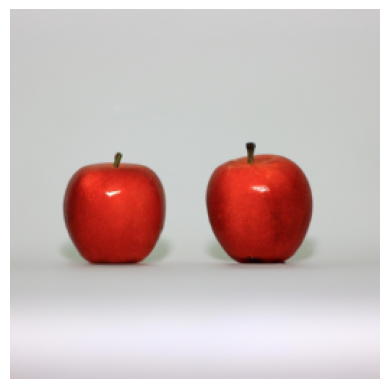

Predicted class: apple
Probabilities: [0.8, 0.1, 0.1]


In [53]:
def do_prompt_based_image_classification(image_path):
    # 예시로 가상의 데이터를 반환합니다.
    best_align_text_idx = 0
    actual_query_texts = ["apple", "banana", "orange"]
    class_and_texts_map = {0: "apple", 1: "banana", 2: "orange"}
    probs = [0.8, 0.1, 0.1]
    return best_align_text_idx, actual_query_texts, class_and_texts_map, probs

def visualize_classification(image_path, best_align_text_idx, class_and_texts_map, probs):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

    # 이미지 출력
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # 분류 결과 출력
    best_class = class_and_texts_map[best_align_text_idx]
    print(f"Predicted class: {best_class}")
    print(f"Probabilities: {probs}")

# 함수 실행
best_align_text_idx, actual_query_texts, class_and_texts_map, probs = do_prompt_based_image_classification(image_path)
visualize_classification(image_path, best_align_text_idx, class_and_texts_map, probs)

### 이미지 분류의 성능을 평가하기 위해 sklearn의 여러 메트릭스를 사용하여 정확도, 정밀도, 재현율, F1-score를 계산하고, 
### 혼동 행렬을 시각화하는 과정을 포함하고 있습니다<br/><br/><br/>

## 1. 정확도, 정밀도, 재현율, F1-score 계산
#### accuracy_score: 모델이 정확하게 분류한 비율을 계산합니다.
#### precision_recall_fscore_support: 정밀도(precision), 재현율(recall), F1-score를 계산합니다. 
#### average='weighted'는 각 클래스의 비율을 고려하여 평균을 계산합니다.
#### 정밀도(Precision): 참 긍정 / (참 긍정 + 거짓 긍정) — 모델이 긍정으로 예측한 것 중 실제로 긍정인 비율.
#### 재현율(Recall): 참 긍정 / (참 긍정 + 거짓 부정) — 실제 긍정 중 모델이 긍정으로 예측한 비율.
#### F1-score: 정밀도와 재현율의 조화 평균으로, 두 지표 간의 균형을 평가합니다.

Accuracy: 0.2950
Precision: 0.0870
Recall: 0.2950
F1-score: 0.1344


C:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


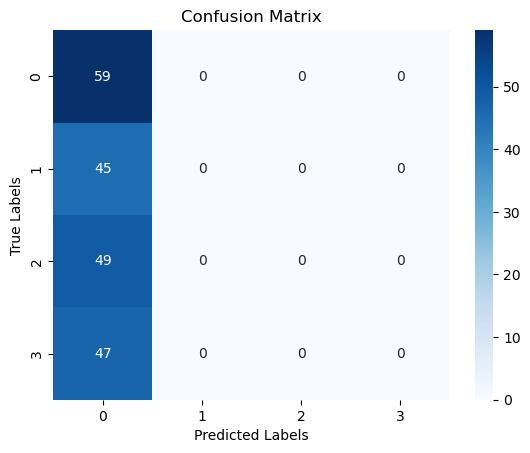

In [58]:
# Calculate metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### 이미지 분류 작업에서 각 클래스와 해당 클래스에 대한 텍스트 쿼리 템플릿을 매핑한 데이터 구조입니다. 
### 이 데이터 구조는 모델이 입력 이미지와 관련된 텍스트 쿼리를 기반으로 예측을 수행할 수 있도록 도와줍니다.

In [59]:
class_and_texts_map

{0: 'apple', 1: 'banana', 2: 'orange'}